In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

## Define FCN16s model for deconvolution layers

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [3]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [4]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [5]:
batch_size = 12
epochs     = 100  #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 12
gamma      = 0.5
n_class = 4
model_use = "fcn"

## Define path, directory trainning environment

In [6]:
# get data
data_dir  = os.path.join("/media/arg_ws3/5E703E3A703E18EB/data/subt_all")
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 1.6476802825927734


In [7]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w

class product_dataset(Dataset):

    def __init__(self, csv_file, phase, n_class=n_class, flip_rate=0.):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name   = self.data.iloc[idx, 0]
        img        = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
        label_name = self.data.iloc[idx, 1]
        label      = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
        #print(os.path.join(data_dir, label_name))
        origin_img = img
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        
        for i in range(n_class):
            target[i][label == i] = 1
        
        #target[0][label == 0] = 1
        #print(np.unique(label))
        
 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [17]:
# initial dataloader for trainning and validation
train_file = os.path.join(data_dir, "train.csv")
val_file   = os.path.join(data_dir, "test.csv")
train_data = product_dataset(csv_file = train_file, phase = 'train')
val_data   = product_dataset(csv_file = val_file, phase = 'val', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 4, num_workers = 0)

dataiter = iter(val_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

In [9]:
len(dataiter)

32

## Train

In [12]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
        configs    = "FCNs_batch{}_epoch{}_RMSprop_lr{}"\
            .format(batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch+1, iter, loss.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        if epoch % 4 == 0:
            torch.save(fcn_model.state_dict(),model_path + '.pkl')

        val(epoch)

## Evaluation

In [13]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [14]:
train()

epoch1, iter0, loss: 0.7664926052093506
epoch1, iter10, loss: 0.7340725064277649
epoch1, iter20, loss: 0.7263068556785583
epoch1, iter30, loss: 0.7248256802558899
epoch1, iter40, loss: 0.7185244560241699
epoch1, iter50, loss: 0.7138192057609558
epoch1, iter60, loss: 0.7081699967384338
epoch1, iter70, loss: 0.6998955011367798
epoch1, iter80, loss: 0.6949978470802307
epoch1, iter90, loss: 0.6983462572097778
epoch1, iter100, loss: 0.6808359026908875
epoch1, iter110, loss: 0.696042001247406
epoch1, iter120, loss: 0.680485188961029
epoch1, iter130, loss: 0.6740436553955078
epoch1, iter140, loss: 0.6668791770935059
epoch1, iter150, loss: 0.669926643371582
epoch1, iter160, loss: 0.6758497357368469
epoch1, iter170, loss: 0.6602673530578613
epoch1, iter180, loss: 0.6652579307556152
epoch1, iter190, loss: 0.6673611402511597
epoch1, iter200, loss: 0.662163496017456
epoch1, iter210, loss: 0.6624912023544312
epoch1, iter220, loss: 0.6535129547119141
epoch1, iter230, loss: 0.6575226783752441
epoch1,

epoch6, iter170, loss: 0.2538340389728546
epoch6, iter180, loss: 0.21788856387138367
epoch6, iter190, loss: 0.2193455994129181
epoch6, iter200, loss: 0.2181238979101181
epoch6, iter210, loss: 0.20977099239826202
epoch6, iter220, loss: 0.2139763981103897
epoch6, iter230, loss: 0.23157942295074463
epoch6, iter240, loss: 0.20561549067497253
epoch6, iter250, loss: 0.20597761869430542
epoch6, iter260, loss: 0.20320479571819305
epoch6, iter270, loss: 0.20250289142131805
epoch6, iter280, loss: 0.203074112534523
Finish epoch 5, time elapsed 550.3114387989044
epoch5, pix_acc: 0.9981588990660919, meanIoU: 0.8893395937800929, IoUs: [0.88741013 0.82484571 0.95576294], recall: [0.94505227 0.93872736 0.98383398], precision: [0.93568815 0.87178188 0.97101247], fscore: [0.9403469  0.90401693 0.97738117]
epoch7, iter0, loss: 0.18881063163280487
epoch7, iter10, loss: 0.1956758052110672
epoch7, iter20, loss: 0.1902330368757248
epoch7, iter30, loss: 0.19050271809101105
epoch7, iter40, loss: 0.185778439044

Finish epoch 10, time elapsed 550.1176285743713
epoch10, pix_acc: 0.9983492294567861, meanIoU: 0.9021871692273477, IoUs: [0.89405655 0.85398497 0.95851999], recall: [0.94051071 0.93188813 0.97258062], precision: [0.9476469  0.91083755 0.98514145], fscore: [0.94406532 0.9212426  0.97882074]
epoch12, iter0, loss: 0.022860875353217125
epoch12, iter10, loss: 0.022976312786340714
epoch12, iter20, loss: 0.021780073642730713
epoch12, iter30, loss: 0.02185167744755745
epoch12, iter40, loss: 0.02311268262565136
epoch12, iter50, loss: 0.022301603108644485
epoch12, iter60, loss: 0.020798951387405396
epoch12, iter70, loss: 0.020816417410969734
epoch12, iter80, loss: 0.020214471966028214
epoch12, iter90, loss: 0.019621197134256363
epoch12, iter100, loss: 0.019321927800774574
epoch12, iter110, loss: 0.01995180733501911
epoch12, iter120, loss: 0.018809814006090164
epoch12, iter130, loss: 0.018625153228640556
epoch12, iter140, loss: 0.01791297271847725
epoch12, iter150, loss: 0.017812522128224373
epoc

epoch17, iter0, loss: 0.005041566211730242
epoch17, iter10, loss: 0.005274726077914238
epoch17, iter20, loss: 0.004945936147123575
epoch17, iter30, loss: 0.0052244216203689575
epoch17, iter40, loss: 0.00511342054232955
epoch17, iter50, loss: 0.0053489599376916885
epoch17, iter60, loss: 0.004933309741318226
epoch17, iter70, loss: 0.004924497567117214
epoch17, iter80, loss: 0.004661125596612692
epoch17, iter90, loss: 0.004852564074099064
epoch17, iter100, loss: 0.0048472099006175995
epoch17, iter110, loss: 0.004702780395746231
epoch17, iter120, loss: 0.004477304872125387
epoch17, iter130, loss: 0.004881901200860739
epoch17, iter140, loss: 0.004672225099056959
epoch17, iter150, loss: 0.0046082730405032635
epoch17, iter160, loss: 0.0047331457026302814
epoch17, iter170, loss: 0.004326758906245232
epoch17, iter180, loss: 0.004613655153661966
epoch17, iter190, loss: 0.004578939639031887
epoch17, iter200, loss: 0.004252689424902201
epoch17, iter210, loss: 0.004761036019772291
epoch17, iter220,

epoch22, iter50, loss: 0.001851324806921184
epoch22, iter60, loss: 0.002128779422491789
epoch22, iter70, loss: 0.0019566400442272425
epoch22, iter80, loss: 0.0038111195899546146
epoch22, iter90, loss: 0.002167751546949148
epoch22, iter100, loss: 0.0020309274550527334
epoch22, iter110, loss: 0.0018635079031810164
epoch22, iter120, loss: 0.0021915279794484377
epoch22, iter130, loss: 0.0022076917812228203
epoch22, iter140, loss: 0.0019504722440615296
epoch22, iter150, loss: 0.0020415496546775103
epoch22, iter160, loss: 0.0066200499422848225
epoch22, iter170, loss: 0.002166870515793562
epoch22, iter180, loss: 0.0018514913972467184
epoch22, iter190, loss: 0.0017235897248610854
epoch22, iter200, loss: 0.0018417263636365533
epoch22, iter210, loss: 0.0016432274132966995
epoch22, iter220, loss: 0.0018175682052969933
epoch22, iter230, loss: 0.0022557605989277363
epoch22, iter240, loss: 0.002044521737843752
epoch22, iter250, loss: 0.0021653426811099052
epoch22, iter260, loss: 0.001537245116196572

epoch27, iter90, loss: 0.0016635118518024683
epoch27, iter100, loss: 0.001247461885213852
epoch27, iter110, loss: 0.0012013018131256104
epoch27, iter120, loss: 0.0014173497911542654
epoch27, iter130, loss: 0.0015764153795316815
epoch27, iter140, loss: 0.0018708279822021723
epoch27, iter150, loss: 0.0018238722113892436
epoch27, iter160, loss: 0.001619604416191578
epoch27, iter170, loss: 0.0014013772597536445
epoch27, iter180, loss: 0.0013431680854409933
epoch27, iter190, loss: 0.0013113244203850627
epoch27, iter200, loss: 0.0014149785274639726
epoch27, iter210, loss: 0.00484313303604722
epoch27, iter220, loss: 0.0014313473366200924
epoch27, iter230, loss: 0.0013714178930968046
epoch27, iter240, loss: 0.0014346318785101175
epoch27, iter250, loss: 0.0011940723052248359
epoch27, iter260, loss: 0.0013283967273309827
epoch27, iter270, loss: 0.0020800866186618805
epoch27, iter280, loss: 0.0013583472464233637
Finish epoch 26, time elapsed 550.5215127468109
epoch26, pix_acc: 0.9985451550066312,

epoch32, iter130, loss: 0.001249136170372367
epoch32, iter140, loss: 0.0010251692729070783
epoch32, iter150, loss: 0.0009584799408912659
epoch32, iter160, loss: 0.001487012836150825
epoch32, iter170, loss: 0.0008975201635621488
epoch32, iter180, loss: 0.0013855989091098309
epoch32, iter190, loss: 0.0012094156118109822
epoch32, iter200, loss: 0.0010801891330629587
epoch32, iter210, loss: 0.0010746162151917815
epoch32, iter220, loss: 0.0011498068924993277
epoch32, iter230, loss: 0.0011662952601909637
epoch32, iter240, loss: 0.0014323577051982284
epoch32, iter250, loss: 0.0013436498120427132
epoch32, iter260, loss: 0.0014318559551611543
epoch32, iter270, loss: 0.0014296872541308403
epoch32, iter280, loss: 0.0014053538907319307
Finish epoch 31, time elapsed 550.5946280956268
epoch31, pix_acc: 0.9985410277133068, meanIoU: 0.9113025620757627, IoUs: [0.90709914 0.86400205 0.96280649], recall: [0.95194827 0.89377668 0.98472873], precision: [0.95062629 0.9628745  0.97740035], fscore: [0.9512868

KeyboardInterrupt: 

## Prediction Result

In [18]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

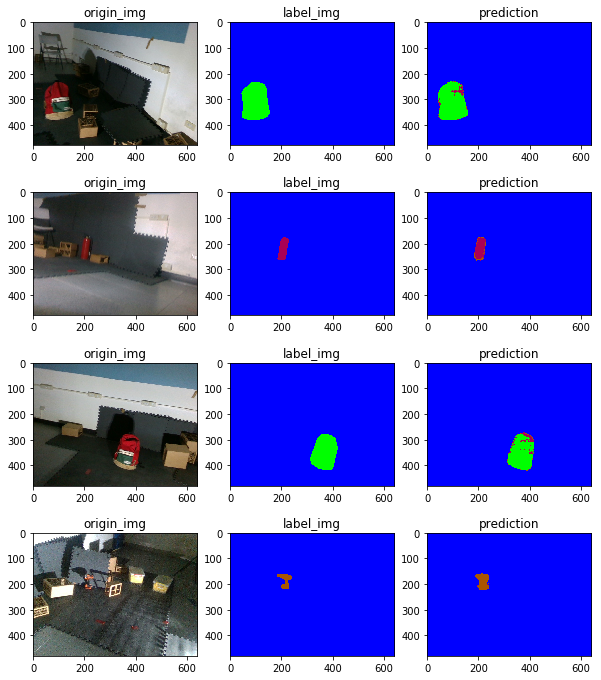

In [19]:
prediction("FCNs_batch12_epoch0_RMSprop_lr0.0001.pkl")